In [1]:
# mlrose dependency workaround: https://stackoverflow.com/a/62354885
import six
import sys
sys.modules['sklearn.externals.six'] = six

from dataclasses import dataclass
from matplotlib import pyplot as plt
import mlrose
import multiprocessing as mp
import numpy as np
import pandas as pd
import time
from typing import Iterable

random_state = 42

In [2]:
class Fitness(object):
    def __init__(self, fitness):
        self.fitness = fitness
        self.count_calls = 0
    def evaluate(self, state):
        self.count_calls += 1
        return self.fitness.evaluate(state)
    def get_prob_type(self):
        return self.fitness.get_prob_type()
    
@dataclass
class RunResult:
    time: float
    num_calls: int
    score: float
    best: Iterable = None
    curve: Iterable = None
    
    
def run_helper(args):
    runner, alg, kwargs = args
    return runner.run(alg, **kwargs) 

class Runner(object):
    def __init__(self, fitness, size):
        self.fitness = Fitness(fitness)
        self.size = size
        self.problem = mlrose.DiscreteOpt(size, self.fitness)
        
    def run(self, alg, **kwargs):
        self.fitness.count_calls = 0
        start = time.time()
        best, score, curve = alg(self.problem, curve=True, **kwargs)
        end = time.time()
        return RunResult(time=end-start, num_calls=self.fitness.count_calls, best=best,
                         score=score, curve=curve)
    
    def run_agg(self, alg, count=20, **kwargs):
        results = [self.run(alg, **kwargs) for _ in range(count)]
        #pool = mp.Pool()
        #results = pool.map(run_helper, [(self, alg, kwargs)] * count)
        times = [res.time for res in results]
        calls = [res.num_calls for res in results]
        scores = [res.score for res in results]
        med_idx = scores.index(np.percentile(scores,50,interpolation='nearest'))
        return RunResult(time=np.median(times), num_calls=np.median(calls), score=scores[med_idx],
                         best=results[med_idx].best, curve=results[med_idx].curve)


In [3]:
 np.seterr(over='ignore' )

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
#checking problem size with default settings of random optimization algorithms
rhcs, sas, gas = [], [], []
for prob_size in [20, 40, 60, 80,100]:
    runner = Runner(mlrose.FourPeaks(), prob_size)
    print(prob_size)
    rhcs.append(runner.run_agg(mlrose.random_hill_climb, restarts=10))
    sas.append(runner.run_agg(mlrose.simulated_annealing))
    gas.append(runner.run_agg(mlrose.genetic_alg, pop_size=200, mutation_prob=0.1))
    

20
40
60
80
100


In [5]:
rhcs, sas, gas

([RunResult(time=0.008320927619934082, num_calls=187.5, score=27.0, best=array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0]), curve=array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  2.,
          2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
          3.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,
          2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  5.,  8.,  8.,
          8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  3.,  3.,  3.,  3.,
          3., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  4., 24., 24., 24., 24., 24., 24., 24., 24.,
         24., 24., 24.,  3.,  3.,  3.,  3.,  3.,  3.,  5.,  5.,  5.,  5.,
          5.,  5.,  5.,  5.,  5.,  5.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  1.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
          3.,  3.,  3.])),
  RunResult(t

In [13]:
mim = []
for prob_size in [20, 40, 60, 80,100]:
    runner = Runner(mlrose.FourPeaks(), prob_size)
    print(prob_size)
    #rhcs.append(runner.run_agg(mlrose.random_hill_climb, restarts=10))
    #sas.append(runner.run_agg(mlrose.simulated_annealing))
    #gas.append(runner.run_agg(mlrose.genetic_alg, pop_size=200, mutation_prob=0.1))
    mim.append(runner.run_agg(mlrose.mimic, pop_size=200, count=5))

20
40
60
80
100


In [ ]:
#fitness values
rhc_score = [rhc.score for rhc in rhcs]
sas_score=[saas.score for saas in sas ]
gas_score=[gaas.score for gaas in gas]
mim_score=[mimi.score for mimi in mim]
problem_size = [20, 40, 60, 80,100]

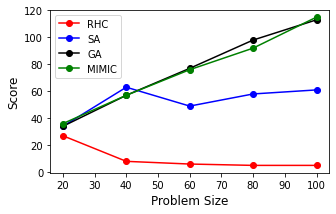

In [17]:
plt.figure(figsize=(5,3))
plt.plot(problem_size,rhc_score, 'o-', color='r', label='RHC')
plt.plot(problem_size,sas_score, 'o-',color='b', label='SA')
plt.plot(problem_size,gas_score, 'o-',color='k', label='GA')
plt.plot(problem_size,mim_score, 'o-',color='g', label='MIMIC')
plt.ylabel('Score', fontsize=12)
plt.xlabel('Problem Size', fontsize=12)
plt.legend(loc='best', fontsize=10)

In [18]:
#number of function calls
rhc_num_calls = [rhc.num_calls for rhc in rhcs]
sas_num_calls =[saas.num_calls for saas in sas ]
gas_num_calls =[gaas.num_calls for gaas in gas ]
mim_num_calls =[mimi.num_calls for mimi in mim ]

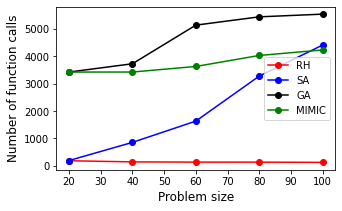

In [19]:
plt.figure(figsize=(5,3))
plt.plot(problem_size,rhc_num_calls, 'o-', color='r', label='RH')
plt.plot(problem_size,sas_num_calls,'o-', color='b', label='SA')
plt.plot(problem_size,gas_num_calls,'o-', color='k', label='GA')
plt.plot(problem_size,mim_num_calls,'o-', color='g', label='MIMIC')
plt.ylabel('Number of function calls',fontsize=12)
plt.xlabel('Problem size',fontsize=12)
plt.legend(loc='best',fontsize=10)

In [20]:
# time taken
rhc_time = [rhc.time for rhc in rhcs]
sas_time=[saas.time for saas in sas ]
gas_time=[gaas.time for gaas in gas ]
mim_time=[mimi.time for mimi in mim ]

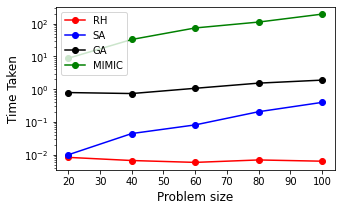

In [21]:
plt.figure(figsize=(5,3))
plt.plot(problem_size,rhc_time, 'o-', color='r', label='RH')
plt.plot(problem_size,sas_time,'o-', color='b', label='SA')
plt.plot(problem_size,gas_time,'o-', color='k', label='GA')
plt.plot(problem_size,mim_time,'o-', color='g', label='MIMIC')
plt.ylabel('Time Taken',fontsize=12)
plt.xlabel('Problem size',fontsize=12)
plt.legend(loc='upper left',fontsize=10)
plt.yscale('log')

In [24]:
#number of iterations
rhc_iter = [len(rhc.curve) for rhc in rhcs]
sas_iter=[len(saas.curve) for saas in sas ]
gas_iter=[len(gaas.curve) for gaas in gas ]
mim_iter=[len(mimi.curve) for mimi in mim ]

In [25]:
rhc_iter

[146, 143, 131, 117, 124]

In [28]:
sas_iter

[119, 567, 1005, 2214, 3483]

In [29]:
gas_iter

[29, 20, 21, 25, 26]

In [30]:
mim_iter

[16, 16, 16, 16, 20]

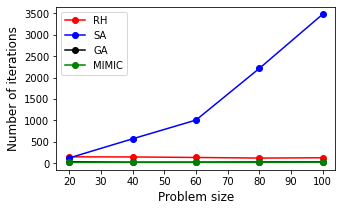

In [31]:
plt.figure(figsize=(5,3))
plt.plot(problem_size,rhc_iter, 'o-', color='r', label='RH')
plt.plot(problem_size,sas_iter,'o-', color='b', label='SA')
plt.plot(problem_size,gas_iter,'o-', color='k', label='GA')
plt.plot(problem_size,mim_iter,'o-', color='g', label='MIMIC')
plt.ylabel('Number of iterations',fontsize=12)
plt.xlabel('Problem size',fontsize=12)
plt.legend(loc='upper left',fontsize=10)

In [ ]:
# hyperparameter tuning for random optimization algorithms

In [ ]:
# hyperparameter tuning for genetic algorithm

In [36]:
gas_hp=[]
for mutation_prob in [0.001, 0.005, 0.01, 0.05,0.1, 0.2]:
    print('mutation_prob',mutation_prob)
    runner = Runner(mlrose.FourPeaks(), 100)
    gas_hp.append(runner.run_agg(mlrose.genetic_alg, pop_size=200, mutation_prob=mutation_prob))

mutation_prob 0.001
mutation_prob 0.005
mutation_prob 0.01
mutation_prob 0.05
mutation_prob 0.1
mutation_prob 0.2


In [39]:
gas_hp_time = [gas_hp1.time for gas_hp1 in gas_hp]

In [43]:
gas_hp_time

[0.5844008922576904,
 0.6363509893417358,
 0.719687819480896,
 0.7417445182800293,
 0.4970118999481201,
 0.5659247636795044]

In [40]:
gas_hp_score = [gas_hp1.score for gas_hp1 in gas_hp]

In [44]:
gas_hp_score 

[16.0, 117.0, 120.0, 120.0, 17.0, 14.0]

In [41]:
mutation_prob=[0.001, 0.005, 0.01, 0.05,0.1, 0.2]

In [46]:
mut=pd.DataFrame(list(zip(gas_hp_score,gas_hp_time,mutation_prob)),columns=['score','time','mutation'])

In [47]:
mut

,score,time,mutation
0,16.0,0.584401,0.001
1,117.0,0.636351,0.005
2,120.0,0.719688,0.010
3,120.0,0.741745,0.050
4,17.0,0.497012,0.100
5,14.0,0.565925,0.200


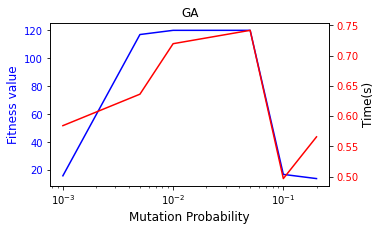

In [111]:
fig,ax1 =plt.subplots(figsize=(5,3))
ax1.set_xlabel('Mutation Probability', fontsize=12)
ax1.set_ylabel('Fitness value', color='b',fontsize=12)
ax1.plot(mutation_prob,gas_hp_score , color='b', label='fitness')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xscale('log')


ax2=ax1.twinx()
ax2.set_ylabel('Time(s)',fontsize=12)
ax2.plot(mutation_prob,gas_hp_time , color='r',label='time')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_xscale('log')
plt.title('GA')
#plt.legend(loc='best',fontsize=10)
plt.show()

In [ ]:
# sa hyperparameter tuning

In [72]:
sa_hp=[]
for schedule in [mlrose.GeomDecay(),mlrose.ArithDecay(),mlrose.ExpDecay()]:
    print('schedule',schedule)
    runner = Runner(mlrose.FourPeaks(), 100)
    sa_hp.append(runner.run_agg(mlrose.simulated_annealing,schedule=schedule)) 

schedule <mlrose.decay.GeomDecay object at 0x122c9df90>
schedule <mlrose.decay.ArithDecay object at 0x122c9d4d0>
schedule <mlrose.decay.ExpDecay object at 0x122c9d210>


In [73]:
sa_hp_time = [sa_hp1.time for sa_hp1 in sa_hp]
sa_hp_score = [sa_hp1.score for sa_hp1 in sa_hp]
schedule_prob=['Geometric_Decay','Arithmetic_Decay','Exp_Decay']
sched=pd.DataFrame(list(zip(sa_hp_score,sa_hp_time,schedule_prob)),columns=['score','time','decay'])
sched

,score,time,decay
0,59.0,0.152116,Geometric_Decay
1,62.0,0.226573,Arithmetic_Decay
2,63.0,0.167912,Exp_Decay


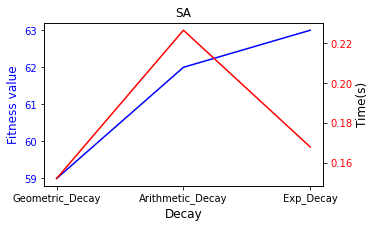

In [112]:
fig,ax1 =plt.subplots(figsize=(5,3))
ax1.set_xlabel('Decay', fontsize=12)
ax1.set_ylabel('Fitness value', color='b',fontsize=12)
ax1.plot(schedule_prob,sa_hp_score , color='b', label='fitness')
ax1.tick_params(axis='y', labelcolor='b')
#ax1.set_xscale('log')


ax2=ax1.twinx()
ax2.set_ylabel('Time(s)',fontsize=12)
ax2.plot(schedule_prob,sa_hp_time , color='r',label='Time(s)')
ax2.tick_params(axis='y', labelcolor='r')
#ax2.set_xscale('log')
#plt.legend(loc='best',fontsize=10)
plt.title('SA')
plt.show()

In [ ]:
# mimic hyperparameter tuning

In [74]:
mimi_hp=[]
for keep_pct in [0.1, 0.2, 0.4]:
    print('keep_pct',keep_pct)
    runner = Runner(mlrose.FourPeaks(), 100)
    mimi_hp.append(runner.run_agg(mlrose.mimic, pop_size=200, count=5, keep_pct=keep_pct))

keep_pct 0.1
keep_pct 0.2
keep_pct 0.4


In [76]:
mimi_hp_time = [gas_hp1.time for gas_hp1 in mimi_hp]
mimi_hp_score = [gas_hp1.score for gas_hp1 in mimi_hp]
keep_prob=[0.1, 0.2, 0.4]
keep=pd.DataFrame(list(zip(mimi_hp_score,mimi_hp_time,keep_prob)),columns=['score','time','keep_pct'])
keep

,score,time,keep_pct
0,115.0,95.775454,0.1
1,114.0,121.261656,0.2
2,114.0,134.854682,0.4


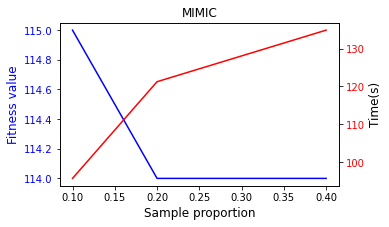

In [114]:
fig,ax1 =plt.subplots(figsize=(5,3))
ax1.set_xlabel('Sample proportion', fontsize=12)
ax1.set_ylabel('Fitness value', color='b',fontsize=12)
ax1.plot(keep_prob,mimi_hp_score, color='b', label='fitness')
ax1.tick_params(axis='y', labelcolor='b')
#ax1.set_xscale('log')


ax2=ax1.twinx()
ax2.set_ylabel('Time(s)',fontsize=12)
ax2.plot(keep_prob,mimi_hp_time  , color='r',label='Time(s)')
ax2.tick_params(axis='y', labelcolor='r')
#ax2.set_xscale('log')
#plt.legend(loc='best',fontsize=10)
plt.title('MIMIC')
plt.show()

In [ ]:
# hyperparameter tuning for random hill climbing

In [82]:
rhc_hp=[]
for restarts in [10,20,40,60,80,100,200]:
    print('restarts',restarts)
    runner = Runner(mlrose.FourPeaks(), 100)
    rhc_hp.append(runner.run_agg(mlrose.random_hill_climb, restarts=restarts))

restarts 10
restarts 20
restarts 40
restarts 60
restarts 80
restarts 100
restarts 200


In [83]:
rhc_hp_time = [rhc_hp1.time for rhc_hp1 in rhc_hp]
rhc_hp_score = [rhc_hp1.score for rhc_hp1 in rhc_hp]
restarts_prob=[10,20,40,60,80,100,200]
restart=pd.DataFrame(list(zip(rhc_hp_score,rhc_hp_time,restarts_prob)),columns=['score','time','restarts'])
restart

,score,time,restarts
0,5.0,0.002976,10
1,7.0,0.005070,20
2,8.0,0.009571,40
3,8.0,0.014291,60
4,9.0,0.019084,80
5,9.0,0.024655,100
6,10.0,0.049556,200


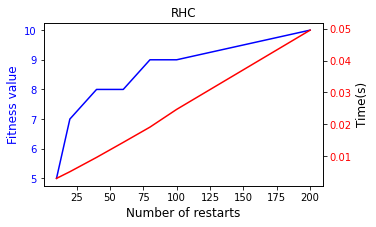

In [115]:
fig,ax1 =plt.subplots(figsize=(5,3))
ax1.set_xlabel('Number of restarts', fontsize=12)
ax1.set_ylabel('Fitness value', color='b',fontsize=12)
ax1.plot(restarts_prob,rhc_hp_score, color='b', label='fitness')
ax1.tick_params(axis='y', labelcolor='b')
#ax1.set_xscale('log')


ax2=ax1.twinx()
ax2.set_ylabel('Time(s)',fontsize=12)
ax2.plot(restarts_prob,rhc_hp_time  , color='r',label='Time(s)')
ax2.tick_params(axis='y', labelcolor='r')
#ax2.set_xscale('log')
#plt.legend(loc='best',fontsize=10)
plt.title('RHC')
plt.show()

In [ ]:
# using tuned hyperparameters for building random oprimization algorithms

In [85]:
rhcs3, sas3, gas3 = [], [], []
for prob_size in [20, 40, 60, 80,100]:
    runner = Runner(mlrose.FourPeaks(), prob_size)
    print(prob_size)
    rhcs3.append(runner.run_agg(mlrose.random_hill_climb, restarts=80))
    sas3.append(runner.run_agg(mlrose.simulated_annealing, schedule=mlrose.ExpDecay()))
    gas3.append(runner.run_agg(mlrose.genetic_alg, pop_size=200, mutation_prob=0.01))

20
40
60
80
100


In [86]:
rhcs3, sas3, gas3

([RunResult(time=0.02984297275543213, num_calls=1369.5, score=32.0, best=array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), curve=array([ 1.,  1.,  1., ..., 30., 30., 30.])),
  RunResult(time=0.024826526641845703, num_calls=1090.0, score=45.0, best=array([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
         0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]), curve=array([ 0.,  0.,  0.,  0.,  0.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
          4.,  4.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,
          3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  2.,  2.,  2.,  2.,
          2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
          2.,  2.,  2.,  2.,  2.,  2.,  2.,  5.,  5.,  5.,  5.,  5.,  5.,
          5.,  5.,  5.,  5.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  2.,  2., 10., 10., 10., 10., 10., 10., 10., 10., 10.,

In [87]:
mim3 = []
for prob_size in [20, 40, 60, 80,100]:
    runner = Runner(mlrose.FourPeaks(), prob_size)
    print(prob_size)
    #rhcs.append(runner.run_agg(mlrose.random_hill_climb, restarts=10))
    #sas.append(runner.run_agg(mlrose.simulated_annealing))
    #gas.append(runner.run_agg(mlrose.genetic_alg, pop_size=200, mutation_prob=0.1))
    mim3.append(runner.run_agg(mlrose.mimic, pop_size=200, count=5, keep_pct=0.1))

20
40
60
80
100


In [88]:
rhc_score3 = [rhc.score for rhc in rhcs3]
sas_score3=[saas.score for saas in sas3 ]
gas_score3=[gaas.score for gaas in gas3]
mim_score3=[mimi.score for mimi in mim3]
problem_size = [20, 40, 60, 80,100]

In [ ]:
# checking fitness value for RO algorithms

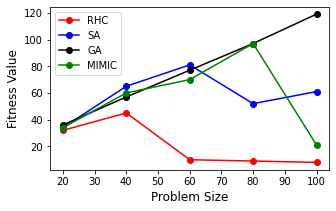

In [116]:
plt.figure(figsize=(5,3))
plt.plot(problem_size,rhc_score3, 'o-', color='r', label='RHC')
plt.plot(problem_size,sas_score3, 'o-',color='b', label='SA')
plt.plot(problem_size,gas_score3, 'o-',color='k', label='GA')
plt.plot(problem_size,mim_score3, 'o-',color='g', label='MIMIC')
plt.ylabel('Fitness Value', fontsize=12)
plt.xlabel('Problem Size', fontsize=12)
plt.legend(loc='best', fontsize=10)

In [ ]:
# checking number of calls for RO algorithms

In [90]:
rhc_num_calls3 = [rhc.num_calls for rhc in rhcs3]
sas_num_calls3 =[saas.num_calls for saas in sas3 ]
gas_num_calls3 =[gaas.num_calls for gaas in gas3 ]
mim_num_calls3 =[mimi.num_calls for mimi in mim3 ]

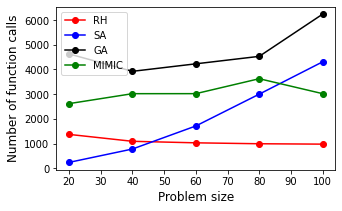

In [91]:
plt.figure(figsize=(5,3))
plt.plot(problem_size,rhc_num_calls3, 'o-', color='r', label='RH')
plt.plot(problem_size,sas_num_calls3,'o-', color='b', label='SA')
plt.plot(problem_size,gas_num_calls3,'o-', color='k', label='GA')
plt.plot(problem_size,mim_num_calls3,'o-', color='g', label='MIMIC')
plt.ylabel('Number of function calls',fontsize=12)
plt.xlabel('Problem size',fontsize=12)
plt.legend(loc='best',fontsize=10)

In [ ]:
# checking time taken for RO algorithms

In [92]:
rhc_time3 = [rhc.time for rhc in rhcs3]
sas_time3=[saas.time for saas in sas3 ]
gas_time3=[gaas.time for gaas in gas3 ]
mim_time3=[mimi.time for mimi in mim3 ]

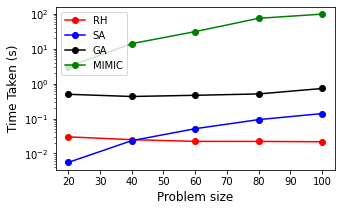

In [96]:
plt.figure(figsize=(5,3))
plt.plot(problem_size,rhc_time3, 'o-', color='r', label='RH')
plt.plot(problem_size,sas_time3,'o-', color='b', label='SA')
plt.plot(problem_size,gas_time3,'o-', color='k', label='GA')
plt.plot(problem_size,mim_time3,'o-', color='g', label='MIMIC')
plt.ylabel('Time Taken (s)',fontsize=12)
plt.xlabel('Problem size',fontsize=12)
plt.legend(loc='upper left',fontsize=10)
plt.yscale('log')

In [122]:
rhc_time3, sas_time3, gas_time3, mim_time3

([0.02984297275543213,
  0.024826526641845703,
  0.022185921669006348,
  0.022119998931884766,
  0.021669864654541016],
 [0.00555109977722168,
  0.02326643466949463,
  0.05113792419433594,
  0.09311091899871826,
  0.13863062858581543],
 [0.4947240352630615,
  0.42782652378082275,
  0.4628840684890747,
  0.506229043006897,
  0.7247161865234375],
 [3.0497682094573975,
  13.950828075408936,
  30.826736211776733,
  74.07871317863464,
  97.62383794784546])

In [ ]:
# checking number of iterations for RO algorithms

In [94]:
rhc_iter3 = [len(rhc.curve) for rhc in rhcs3]
sas_iter3=[len(saas.curve) for saas in sas3 ]
gas_iter3=[len(gaas.curve) for gaas in gas3 ]
mim_iter3=[len(mimi.curve) for mimi in mim3 ]

In [103]:
mim_iter3

[12, 14, 12, 24, 16]

In [104]:
gas_iter3

[22, 28, 22, 21, 33]

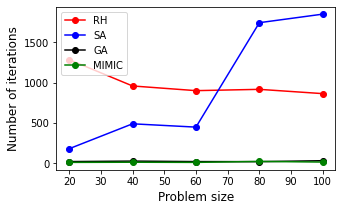

In [95]:
plt.figure(figsize=(5,3))
plt.plot(problem_size,rhc_iter3, 'o-', color='r', label='RH')
plt.plot(problem_size,sas_iter3,'o-', color='b', label='SA')
plt.plot(problem_size,gas_iter3,'o-', color='k', label='GA')
plt.plot(problem_size,mim_iter3,'o-', color='g', label='MIMIC')
plt.ylabel('Number of iterations',fontsize=12)
plt.xlabel('Problem size',fontsize=12)
plt.legend(loc='upper left',fontsize=10)

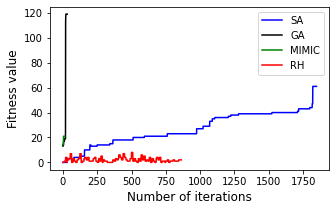

In [109]:
plt.figure(figsize=(5,3))
plt.plot(sas3[4].curve, color='b', label='SA')
plt.plot(gas3[4].curve, color='k', label='GA')
plt.plot(mim3[4].curve, color='g', label='MIMIC')
plt.plot(rhcs3[4].curve, color='r', label='RH')
plt.ylabel('Fitness value',fontsize=12)
plt.xlabel('Number of iterations',fontsize=12)
plt.legend(loc='upper right',fontsize=10)

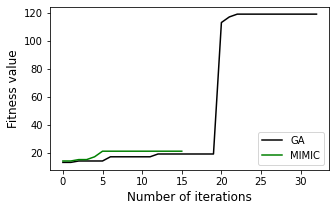

In [119]:
plt.figure(figsize=(5,3))
#plt.plot(sas3[4].curve, color='b', label='SA')
plt.plot(gas3[4].curve, color='k', label='GA')
plt.plot(mim3[4].curve, color='g', label='MIMIC')
#plt.plot(rhcs3[4].curve, color='r', label='RH')
plt.ylabel('Fitness value',fontsize=12)
plt.xlabel('Number of iterations',fontsize=12)
plt.legend(loc='lower right',fontsize=10)

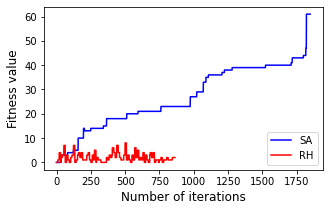

In [120]:
plt.figure(figsize=(5,3))
plt.plot(sas3[4].curve, color='b', label='SA')
#plt.plot(gas3[4].curve, color='k', label='GA')
#plt.plot(mim3[4].curve, color='g', label='MIMIC')
plt.plot(rhcs3[4].curve, color='r', label='RH')
plt.ylabel('Fitness value',fontsize=12)
plt.xlabel('Number of iterations',fontsize=12)
plt.legend(loc='lower right',fontsize=10)

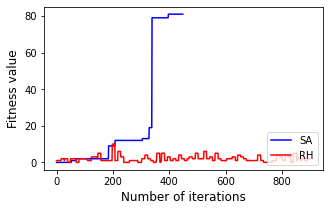

In [121]:
plt.figure(figsize=(5,3))
plt.plot(sas3[2].curve, color='b', label='SA')
#plt.plot(gas3[4].curve, color='k', label='GA')
#plt.plot(mim3[4].curve, color='g', label='MIMIC')
plt.plot(rhcs3[2].curve, color='r', label='RH')
plt.ylabel('Fitness value',fontsize=12)
plt.xlabel('Number of iterations',fontsize=12)
plt.legend(loc='lower right',fontsize=10)

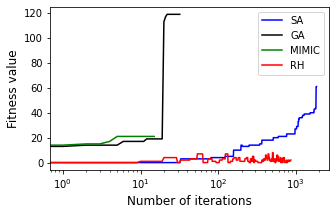

In [117]:
plt.figure(figsize=(5,3))
plt.plot(sas3[4].curve, color='b', label='SA')
plt.plot(gas3[4].curve, color='k', label='GA')
plt.plot(mim3[4].curve, color='g', label='MIMIC')
plt.plot(rhcs3[4].curve, color='r', label='RH')
plt.ylabel('Fitness value',fontsize=12)
plt.xlabel('Number of iterations',fontsize=12)
plt.legend(loc='upper right',fontsize=10)
plt.xscale('log')